In [41]:
import re
import os

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import cantera as ct

from rmgpy.kinetics import PDepArrhenius, Arrhenius

import simulation as ctt

%matplotlib inline

sns.set_style('white')
sns.set_style('ticks')
sns.set_context('paper',font_scale=1.5)

In [42]:
# denotes whether to create 1 figure or four separate figures
multi_panel = False
if multi_panel:
    f2, axes = plt.subplots(nrows=2,ncols=2,figsize = [12,8],gridspec_kw={'wspace':.35,'hspace':0.35})

In [43]:
directory = '../data/mechanism/'
overall_image_path = '../results/'

In [44]:
radical_production_table = pd.read_csv('../data/radical_production_by_pathway.csv', index_col = 'pathways')

# atmospheric figures

In [45]:
def simulate_one_condition(solution, conversion_species, desired_conversion = 0.99, df = None, df_index = None):
    """given a solution object already set to proper conditions, returns the species concentrations
    normalized to the fraction of RO2 reacted"""
    reactor = ct.IdealGasConstPressureReactor(solution, energy='off')
    simulator = ct.ReactorNet([reactor])
    solution = reactor.kinetics
    peroxy_conc = sum([solution.concentrations[solution.species_index(species_name)] for species_name in conversion_species]) * desired_conversion
    outputs = ctt.run_simulation_till_conversion(solution=solution,
                                 species = conversion_species,
                                 conversion = desired_conversion,
                                 condition_type='constant-temperature-and-pressure',
                                 output_reactions=False,
                                 atol=1e-28,
                                 skip_data= 1e9
                       )
    if df is None:
        series = pd.Series()
        for name, conc in outputs['species'].iloc[-1,:].iteritems():
            series[name] = conc / peroxy_conc
        return series
    elif df_index is not None:
        for name, conc in species.iteritems():
            df.loc[df_index,name] = conc / peroxy_conc
    else:
        raise AttributeError('If a dataframe is given, it `df_index` must also be specified')
        

## make atmospheric isomerization plot

In [46]:
colors = sns.color_palette("GnBu_d",n_colors=4)
colors.reverse()

In [47]:
butanol_vars = {
    'input_path': '../data/mechanism/',
    "conversion_species": ['gR', 'gRO2'],
    "starting_alkyl_radical": 'gR',
    # 8 cycles
    "species_to_plot": ['OOCC(CO)C', # hydroperoxy
                       ['[O]CC(CO)C','galdol'],  # NO reaction
                       'OOCC(C=O)C', # isom
                       ['galdoxy','O=CC(C)C=O'], # water formation
                       ['propene','propene3ol'], # r decomp
                        'NO2OCC(CO)C', # nirate formation
                       'galkene', # HO2 alkene
                       ['disub_c4ether','disub_epoxy','monosub_c4ether'], # cyclic ether
                       ['OOCC(C(O[O])O)C','O=CC(C)C(OO)O','OOCC(CO)CO[O]','OCC(O[O])(COO)C','O=CC(CO)COO','OCC(OO)(C=O)C'],# chain oxidation
                      ],
    "in_legend": ['hydroperoxy', 'alkoxy','alkoxy_isom','water loss','R decomposition','nitrate','cyclic ether','HO2 elimination','isomerization'],
    'image_path': '../results/',
    'reactions_to_remove': None,
#    """products not accounted for in the above scheme:
#       
#       OOCC(C=O)C - from the H-transfer from hydroxyl group followed by disproportionation by O2
#       CC=CO - from the double \beta scission pathway with semi-high barrier
#       """
}
butanol_vars['cantera_input_file'] =  os.path.join(butanol_vars['input_path'],'gamma_i_butanol.cti')

In [48]:
variables = butanol_vars

cantera_input_file = variables['cantera_input_file']
species_to_plot = variables['species_to_plot']
starting_alkyl_radical = variables['starting_alkyl_radical']
in_legend = variables['in_legend']
image_path = variables['image_path']
conversion_species = variables['conversion_species']
reactions_to_remove = variables['reactions_to_remove']

# get expected products
expected_products = []
for item in species_to_plot:
    if isinstance(item,list):
        for item2 in item:
            expected_products.append(item2)
    else:
        expected_products.append(item)

In [49]:
# first element is RO2, second is the isomerization rate for 6 membered ring shift (from Otkjaer), third is number carbons, and forth is if there are additional functional groups for calculating NO reactivity
atm_compounds_to_rates = [('H', 2.66e-4, 4,None),
                          ('CH$_3$', 7.67e-3, 5,None),
                          ('OH', 4.51e-2, 4, 'OH'),
                          ('C=C', 6.13e-1, 6, None),]

In [50]:
from rmgpy.chemkin import load_chemkin_file

In [51]:
rxn_change_rate = 'gRO2 <=> gQOOHa'
# list of species missing the C-H bond with modified strength 
# (enthalpy lowered with with weaker CH bond strength)
species_change_enthalpy = ['gQOOHa','galdoxy','disub_c4ether',
                           'propen1ol','OOCC(C(O[O])O)C','O=CC(C)C(OO)O']

In [52]:
def adjust_NO_rates_to_cnum(reactions_rmg, carbon_num, other_functional_groups=None):
    if carbon_num == 4:
        # atkinson 1997 with C4 compound
        if other_functional_groups == 'OH':
            oxy_rates = PDepArrhenius(pressures=([0.01,0.1,1,10,100],'bar'), arrhenius=[Arrhenius(A=(1.62791e+06,'m^3/(mol*s)'), n=-0.000141688, Ea=(-2.99104,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 1.00026, dn = +|- 3.56474e-05, dEa = +|- 0.000159204 kJ/mol"""), Arrhenius(A=(1.67071e+06,'m^3/(mol*s)'), n=-0.00346841, Ea=(-2.96676,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 1.00166, dn = +|- 0.000225047, dEa = +|- 0.00100507 kJ/mol"""), Arrhenius(A=(2.03697e+06,'m^3/(mol*s)'), n=-0.0292964, Ea=(-2.80448,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 1.02194, dn = +|- 0.00293612, dEa = +|- 0.0131129 kJ/mol"""), Arrhenius(A=(3.14328e+06,'m^3/(mol*s)'), n=-0.0858879, Ea=(-2.45349,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 1.06894, dn = +|- 0.00901984, dEa = +|- 0.0402832 kJ/mol"""), Arrhenius(A=(5.27984e+06,'m^3/(mol*s)'), n=-0.153785, Ea=(-2.0467,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 1.14607, dn = +|- 0.0184475, dEa = +|- 0.0823876 kJ/mol""")])
            nit_rates = PDepArrhenius(pressures=([0.01,0.1,1,10,100],'bar'), arrhenius=[Arrhenius(A=(1.70409e+26,'m^3/(mol*s)'), n=-8.08735, Ea=(16.1936,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 4.84581, dn = +|- 0.213524, dEa = +|- 0.953612 kJ/mol"""), Arrhenius(A=(2.85071e+31,'m^3/(mol*s)'), n=-9.75679, Ea=(17.3031,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 3.27964, dn = +|- 0.160704, dEa = +|- 0.717715 kJ/mol"""), Arrhenius(A=(5.48873e+32,'m^3/(mol*s)'), n=-10.2261, Ea=(14.0354,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 2.26894, dn = +|- 0.110856, dEa = +|- 0.49509 kJ/mol"""), Arrhenius(A=(1.54367e+32,'m^3/(mol*s)'), n=-10.1042, Ea=(10.2928,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 4.84154, dn = +|- 0.213405, dEa = +|- 0.953079 kJ/mol"""), Arrhenius(A=(1.03115e+31,'m^3/(mol*s)'), n=-9.76159, Ea=(7.3855,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 6.05837, dn = +|- 0.243741, dEa = +|- 1.08856 kJ/mol""")])
        else:
            oxy_rates = PDepArrhenius(pressures=([0.01,0.1,1,10,100],'bar'), arrhenius=[Arrhenius(A=(1.62989e+06,'m^3/(mol*s)'), n=-0.00028359, Ea=(-2.98905,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 1.00053, dn = +|- 7.1288e-05, dEa = +|- 0.000318377 kJ/mol"""), Arrhenius(A=(1.717e+06,'m^3/(mol*s)'), n=-0.00695881, Ea=(-2.94034,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 1.00333, dn = +|- 0.000450401, dEa = +|- 0.00201152 kJ/mol"""), Arrhenius(A=(2.57144e+06,'m^3/(mol*s)'), n=-0.0595939, Ea=(-2.61009,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 1.0457, dn = +|- 0.00604659, dEa = +|- 0.0270045 kJ/mol"""), Arrhenius(A=(6.46385e+06,'m^3/(mol*s)'), n=-0.179892, Ea=(-1.86694,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 1.1544, dn = +|- 0.0194269, dEa = +|- 0.0867618 kJ/mol"""), Arrhenius(A=(2.08917e+07,'m^3/(mol*s)'), n=-0.333554, Ea=(-0.950904,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 1.35986, dn = +|- 0.0415896, dEa = +|- 0.185742 kJ/mol""")])
            nit_rates = PDepArrhenius(pressures=([0.01,0.1,1,10,100],'bar'), arrhenius=[Arrhenius(A=(3.40817e+26,'m^3/(mol*s)'), n=-8.08735, Ea=(16.1936,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 4.84581, dn = +|- 0.213524, dEa = +|- 0.953612 kJ/mol"""), Arrhenius(A=(5.70142e+31,'m^3/(mol*s)'), n=-9.75679, Ea=(17.3031,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 3.27964, dn = +|- 0.160704, dEa = +|- 0.717715 kJ/mol"""), Arrhenius(A=(1.09775e+33,'m^3/(mol*s)'), n=-10.2261, Ea=(14.0354,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 2.26894, dn = +|- 0.110856, dEa = +|- 0.49509 kJ/mol"""), Arrhenius(A=(3.08733e+32,'m^3/(mol*s)'), n=-10.1042, Ea=(10.2928,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 4.84154, dn = +|- 0.213405, dEa = +|- 0.953079 kJ/mol"""), Arrhenius(A=(2.0623e+31,'m^3/(mol*s)'), n=-9.76159, Ea=(7.3855,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 6.05837, dn = +|- 0.243741, dEa = +|- 1.08856 kJ/mol""")])
    elif carbon_num == 6:
        # atkinson 1997 with C6 compound
        oxy_rates = PDepArrhenius(pressures=([0.01,0.1,1,10,100],'bar'), arrhenius=[Arrhenius(A=(1.68526e+06,'m^3/(mol*s)'), n=-0.00454971, Ea=(-2.95684,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 1.00246, dn = +|- 0.000332503, dEa = +|- 0.00148498 kJ/mol"""), Arrhenius(A=(2.30919e+06,'m^3/(mol*s)'), n=-0.0455447, Ea=(-2.69638,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 1.03179, dn = +|- 0.00423455, dEa = +|- 0.0189118 kJ/mol"""), Arrhenius(A=(5.47591e+06,'m^3/(mol*s)'), n=-0.158252, Ea=(-2.00092,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 1.13618, dn = +|- 0.0172748, dEa = +|- 0.0771506 kJ/mol"""), Arrhenius(A=(1.81413e+07,'m^3/(mol*s)'), n=-0.315039, Ea=(-1.05987,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 1.33061, dn = +|- 0.0386474, dEa = +|- 0.172602 kJ/mol"""), Arrhenius(A=(3.06698e+07,'m^3/(mol*s)'), n=-0.383874, Ea=(-0.652728,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 1.43924, dn = +|- 0.049266, dEa = +|- 0.220025 kJ/mol""")])
        nit_rates = PDepArrhenius(pressures=([0.01,0.1,1,10,100],'bar'), arrhenius=[Arrhenius(A=(1.63185e+31,'m^3/(mol*s)'), n=-9.57746, Ea=(17.4858,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 3.59183, dn = +|- 0.173007, dEa = +|- 0.772661 kJ/mol"""), Arrhenius(A=(1.03591e+33,'m^3/(mol*s)'), n=-10.208, Ea=(14.6645,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 2.25274, dn = +|- 0.109886, dEa = +|- 0.490758 kJ/mol"""), Arrhenius(A=(4.61699e+32,'m^3/(mol*s)'), n=-10.1525, Ea=(10.8772,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 4.20469, dn = +|- 0.194323, dEa = +|- 0.867858 kJ/mol"""), Arrhenius(A=(2.60693e+31,'m^3/(mol*s)'), n=-9.79142, Ea=(7.63357,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 6.02038, dn = +|- 0.24289, dEa = +|- 1.08476 kJ/mol"""), Arrhenius(A=(1.41591e+31,'m^3/(mol*s)'), n=-9.71495, Ea=(6.87658,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 6.42849, dn = +|- 0.251764, dEa = +|- 1.12439 kJ/mol""")])

    elif carbon_num == 5:
        # atkinson 1997 with C5 compound
        oxy_rates = PDepArrhenius(pressures=([0.01,0.1,1,10,100],'bar'), arrhenius=[Arrhenius(A=(1.62791e+06,'m^3/(mol*s)'), n=-0.000141688, Ea=(-2.99104,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 1.00026, dn = +|- 3.56474e-05, dEa = +|- 0.000159204 kJ/mol"""), Arrhenius(A=(1.67071e+06,'m^3/(mol*s)'), n=-0.00346841, Ea=(-2.96676,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 1.00166, dn = +|- 0.000225047, dEa = +|- 0.00100507 kJ/mol"""), Arrhenius(A=(2.03697e+06,'m^3/(mol*s)'), n=-0.0292964, Ea=(-2.80448,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 1.02194, dn = +|- 0.00293612, dEa = +|- 0.0131129 kJ/mol"""), Arrhenius(A=(3.14328e+06,'m^3/(mol*s)'), n=-0.0858879, Ea=(-2.45349,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 1.06894, dn = +|- 0.00901984, dEa = +|- 0.0402832 kJ/mol"""), Arrhenius(A=(5.27984e+06,'m^3/(mol*s)'), n=-0.153785, Ea=(-2.0467,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 1.14607, dn = +|- 0.0184475, dEa = +|- 0.0823876 kJ/mol""")])
        nit_rates = PDepArrhenius(pressures=([0.01,0.1,1,10,100],'bar'), arrhenius=[Arrhenius(A=(1.70409e+26,'m^3/(mol*s)'), n=-8.08735, Ea=(16.1936,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 4.84581, dn = +|- 0.213524, dEa = +|- 0.953612 kJ/mol"""), Arrhenius(A=(2.85071e+31,'m^3/(mol*s)'), n=-9.75679, Ea=(17.3031,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 3.27964, dn = +|- 0.160704, dEa = +|- 0.717715 kJ/mol"""), Arrhenius(A=(5.48873e+32,'m^3/(mol*s)'), n=-10.2261, Ea=(14.0354,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 2.26894, dn = +|- 0.110856, dEa = +|- 0.49509 kJ/mol"""), Arrhenius(A=(1.54367e+32,'m^3/(mol*s)'), n=-10.1042, Ea=(10.2928,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 4.84154, dn = +|- 0.213405, dEa = +|- 0.953079 kJ/mol"""), Arrhenius(A=(1.03115e+31,'m^3/(mol*s)'), n=-9.76159, Ea=(7.3855,'kJ/mol'), T0=(1,'K'), Tmin=(250,'K'), Tmax=(1250,'K'), comment="""Fitted to 20 data points; dA = *|/ 6.05837, dn = +|- 0.243741, dEa = +|- 1.08856 kJ/mol""")])
        
    else:
        raise AttributeError("heavy atom number {} is not currently supported. "\
                            'Obtain values from nitrate branching ratio notebook.'\
                            ''.format(heavy_atom_num))
    reactions_rmg[0].kinetics = oxy_rates
    reactions_rmg[2].kinetics = nit_rates
    return reactions_rmg

In [53]:
def get_solution_object_changed_rates(rxn_change_rate, species_change_enthalpy, target_rate, 
                                      directory = '../data/20180102_current_chemkin_cantera_files/',
                                      chemkin_file_name = 'gamma_i_butanol_high_p.inp',
                                      species_dictionary_name = 'butanol_species_dictionary.txt',
                                      adjust_NO_rates=False, heavy_atom_num=5,
                                      other_functional_groups=None):
    """
    This method returns a cantera solution object, given a target isomerization rate
    `target rate` which has units of inverse seconds. The reaction barrier height is modified
    by `alpha` which uses Evany-Polanyi relationship. Species which don't have the bond
    whose strength is changed, listed as `species_change_enthalpy` get a change in enthalpy
    equal to bond change.
    A cantera solution object is returned.
    """
    
    # import chemkin in RMG
    species_rmg, reactions_rmg = load_chemkin_file(os.path.join(directory,chemkin_file_name),
                                                dictionary_path=os.path.join(directory,species_dictionary_name),
                                                use_chemkin_names=True)
    for rxn in reactions_rmg:
        if str(rxn) == rxn_change_rate:
            # si is in J/mol
            A = rxn.kinetics.A.value_si
            n = rxn.kinetics.n.value_si
            
            target_Ea = -8.314 * 298.15 * np.log(target_rate/A/(298.15**n))
            Ea_change = target_Ea - rxn.kinetics.Ea.value_si
            rxn.kinetics.Ea.value_si = target_Ea
    # modify rate constants in rmg
    for species in species_rmg:
        if species.label in species_change_enthalpy:
            species.thermo.change_base_enthalpy(Ea_change)
    if adjust_NO_rates:
        reactions_rmg = adjust_NO_rates_to_cnum(reactions_rmg, heavy_atom_num, other_functional_groups)
    # convert to solution object
    species_cantera = []
    for species in species_rmg:
        species_cantera.append(species.to_cantera())
    reactions_cantera = []
    for rxn in reactions_rmg:
        reactions_cantera.append(rxn.to_cantera())
    return ct.Solution(thermo='IdealGas', kinetics='GasKinetics',
                           species=species_cantera, 
                           reactions=reactions_cantera)


In [54]:
temperatures = [298.15]
pressures = [1e5]

In [55]:
NO_values = np.logspace(-12,-6,50)

In [56]:
reaction_index=None

In [57]:
simulation_output = []
for group, target_rate, carbon_number,other_fg in atm_compounds_to_rates:
    solution = get_solution_object_changed_rates(rxn_change_rate=rxn_change_rate, 
                                     species_change_enthalpy=species_change_enthalpy,
                                     target_rate=target_rate,
                                      directory = '../data/mechanism/',
                                      chemkin_file_name = 'butanol_high_p.inp',
                                      species_dictionary_name = 'species_dictionary_butanol.txt',
                                        adjust_NO_rates = True, heavy_atom_num=carbon_number,
                                        other_functional_groups=other_fg)
    rxn_index = solution.reaction_equations().index('gRO2 <=> gQOOHa')
    for NO in NO_values:
        initialMoleFractions={
                    "NO": NO,
                    "HO2": 1e-11,
                    starting_alkyl_radical: 1e-17,
                    'O2': 0.21,
                    "N2": 0.79,
                }
        for temperature in temperatures:
            for pressure in pressures:
                conditions = temperature, pressure, initialMoleFractions
                solution.TPX = conditions        

                series = simulate_one_condition(solution, conversion_species=conversion_species,)
                series['R group'] = group
                series['NO (frac)'] = NO
                series['temp (K)'] = temperature
                series['pres (Pa)'] = pressure
                series['qooh enthalpy (J/kmol)'] = solution.species(solution.species_index('gQOOHa')).thermo.h(298)
                series['isom rate (s^-1)'] = solution.forward_rate_constants[rxn_index]
                simulation_output.append(series)

/home/mark/anaconda3/envs/rmg_env3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [58]:
simulation_output = pd.DataFrame(simulation_output)

In [59]:
branching_ratio_data = []
for index in simulation_output.index:
    plotted_element_values = []
    for e in species_to_plot:
        #print(e)
        if isinstance(e, list):
            plotted_element_values.append(simulation_output.loc[index,e].sum())
        else: 
            plotted_element_values.append(simulation_output.loc[index,e])
        #print(plotted_element_values[-1])
    branching_ratio_data.append(dict(zip(in_legend,plotted_element_values)))
branching_ratio_data = pd.DataFrame(branching_ratio_data)

In [60]:

branching_ratio_data['NO'] = simulation_output['NO (frac)']
branching_ratio_data['R'] = simulation_output['R group']


In [61]:
plot_data = branching_ratio_data.pivot(index = 'NO', columns = 'R', values = 'isomerization')

In [62]:
plot_data=plot_data[['H','CH$_3$','OH','C=C']]

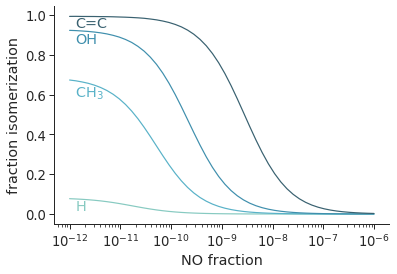

In [63]:
if not multi_panel:
    f, ax = plt.subplots()
else:
    ax = axes[0][0]
plot_data.plot(ax=ax, color=colors,logx=True, legend=False)
ax.set_ylabel('fraction isomerization')
ax.set_xlabel('NO fraction')
ax.annotate('H',(1.3e-12,0.04), color=colors[0], verticalalignment='center',horizontalalignment='left')
ax.annotate('CH$_3$',(1.3e-12,0.61), color=colors[1], verticalalignment='center',horizontalalignment='left')
ax.annotate('OH',(1.3e-12,0.88), color=colors[2], verticalalignment='center',horizontalalignment='left')
ax.annotate('C=C',(1.3e-12,0.96), color=colors[3], verticalalignment='center',horizontalalignment='left')
sns.despine()

In [24]:
if not multi_panel:
    f.savefig(os.path.join(image_path,'isomerization_with_NO_and_structure.svg'),bbox_inches='tight')

# make HOx production plot

In [67]:
functional_groups = ['H','CH$_3$','OH','C=C']

In [68]:
radical_production_series_together = radical_production_table['Hox_together']
radical_production_series = radical_production_table['Hox_split']

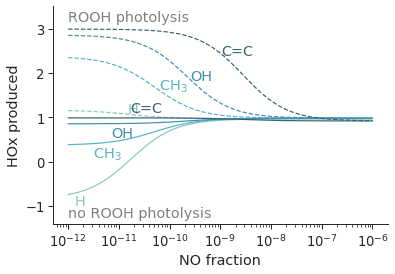

In [69]:
if not multi_panel:
    f, ax = plt.subplots()
else:
    ax = axes[1][0]
ax.set_xscale('log')

for index, f_name in enumerate(functional_groups):
    one_compound_br = branching_ratio_data[branching_ratio_data.R == f_name].copy()
    one_compound_br.index = NO_values
    del one_compound_br['R']
    radical_production = (radical_production_series * one_compound_br).sum(1)
    radical_production_together = (radical_production_series_together * one_compound_br).sum(1)
    ax.plot(radical_production.index, radical_production.values, color=colors[index], linestyle = '--')
    ax.plot(radical_production.index, radical_production_together.values, color=colors[index])
    # annotate bottom lines
    y_cross = radical_production_together[NO_values[2+1*index]]
    if index < 3:
        va = 'top'
        va_adjust = -0.05
    else:
        va = 'bottom'
        va_adjust = 0.05
    ax.annotate(f_name,(NO_values[1+3*index], y_cross + va_adjust), color=colors[index], verticalalignment=va,horizontalalignment='left')
    # annotate top lines
    y_cross = radical_production[NO_values[10+5*index]]
    ax.annotate(f_name,(NO_values[10+5*index]*.9, y_cross -.05), color=colors[index], verticalalignment='bottom',horizontalalignment='left')
ax.annotate('no ROOH photolysis',(1e-12,-1), color=(0.5,0.5,0.5), verticalalignment='top',horizontalalignment='left')
ax.annotate('ROOH photolysis',(1e-12,3.1), color=(0.5,0.5,0.5), verticalalignment='bottom',horizontalalignment='left')
ax.set_ylabel('HOx produced')
ax.set_xlabel('NO fraction')
ax.set_ylim((-1.4,3.5))
sns.despine()

In [28]:
if not multi_panel:
    f.savefig(os.path.join(image_path,'HOx_with_temp_and_structure.svg'),bbox_inches='tight')

## make combustion isomerization plot

In [29]:
colors = sns.color_palette("YlOrRd_d",n_colors=3)
colors.reverse()

In [30]:
butanol_vars = {
    'input_path': directory,
    "conversion_species": ['gR', 'gRO2'],
    "starting_alkyl_radical": 'gR',
    # 8 cycles
    "species_to_plot": ['OOCC(CO)C', # hydroperoxy
                       ['[O]CC(CO)C','galdol'],  # NO reaction
                       'OOCC(C=O)C', # isom
                       ['galdoxy','O=CC(C)C=O'], # water formation
                       ['CC=C','propene3ol'], # r decomp
                        'NO2OCC(CO)C', # nitrate formation
                       'galkene', # HO2 alkene
                       ['disub_c4ether','disub_epoxy','monosub_c4ether'], # cyclic ether
                       ['OOCC(C(O[O])O)C','O=CC(C)C(OO)O','OOCC(CO)CO[O]','OCC(O[O])(COO)C','O=CC(CO)COO','OCC(OO)(C=O)C'],# chain oxidation
                      ],
    "in_legend": ['hydroperoxy', 'alkoxy','isomerization + HO2 production','water loss','R decomposition','nitrate','cyclic ether','HO2 elimination'],
    'image_path': overall_image_path,
    'reactions_to_remove': None,
}
butanol_vars['cantera_input_file'] =  os.path.join(butanol_vars['input_path'],'gamma_i_butanol.cti')


propane_vars = {
    'input_path': directory,
    'conversion_species': ['npropyl','npropyloo'],
    'starting_alkyl_radical': 'npropyl',
    'species_to_plot': ['npropylooh',
                       ['npropyloxy','propanal','CH3CH2OO','CH3CH2OOH'], #the c2 comes from breaking of npropyloxy
                       ['prod_1','CO'], # 1 CO produced by the khp cycle
                       'C3H6',
                       'C2H4',
                       'npropylONO2',
                       'propoxide',
                       'npropanedihydroperoxy',
                       ['prod_2','acrolein']],
    'in_legend': ['hydroperoxy', 'alkoxy','isomerization','HO2 elimination', 'R decomposition','nitrate','cyclic ether','isomerization + hydroperoxide', 'isomerization + HO2 production'],
    'image_path': overall_image_path,
    'reactions_to_remove': ['CH3CH2OO + NO <=> NO2 + ethoxy',
                       'C2H4 + H (+M) <=> C2H5 (+M)',
                       '2 C2H4 <=> C2H3 + C2H5',
                       'C2H5 + CH3 <=> C2H4 + CH4',
                       'C2H5 + H <=> C2H4 + H2',
                       'C2H5 + O2 <=> C2H4 + HO2',
                       'C2H5 + O2 <=> C2H4 + HO2',
                       'C2H5 + allyl <=> C2H4 + C3H6',
                       'CH3CH2OO <=> C2H4 + HO2',
                       'CH2CH2OOH <=> CH3CH2OO',
                       'C2H5 + O2 <=> CH2CH2OOH',
                       'npropyl <=> C3H6 + H',
                       'OH + propanal <=> H2O + propionyl',
                       'HO2 + propanal <=> H2O2 + propionyl',

                      ]
}
propane_vars['cantera_input_file'] =  os.path.join(propane_vars['input_path'],'merchant-full_w_NO.cti')

butane_vars = {
    'input_path': directory,
    "conversion_species": ['PC4H9', 'PC4H9O2'],
    "starting_alkyl_radical": 'PC4H9',
    # 8 cycles
    "species_to_plot": ['PC4H9O2H', # hydroperoxy
                       ['PC4H9O','NC3H7CHO'],  # NO reaction
                       ['C4H8OOH1-3', 'C4H8OOH1-4','C4H8OOH1-3O2','C4H8OOH1-4O2','C4H71-2,4OOH','C4H72-1,3OOH', 'C4H72-1,4OOH','NC4KET13', 'NC4KET14','NC4KET12' ], # isom
                       ['C4H71-4OOH', 'C4H72-1OOH','C4H71-3OOH'], # isom producing first HO2
                       ['C4H7O1-2OOH-4','C4H7O1-4OOH-2', 'C4H7O1-2OOH-3', 'C4H7O2-3OOH-1', 'C4H7O1-3OOH-4', ], # ether OOH compoiund (produces 2 radicals)
                        ['C3H6','C2H4'], # r decomp
                        'PC4H9ONO2', # nitrate formation
                       'C4H8-1', # HO2 alkene
                       ['C4H8O1-2','C4H8O1-3','C4H8O1-4',], # cyclic ether
                       ],
    "reactions_to_remove":['C2H5 + O2 <=> C2H4 + HO2', # separate C2H5 and C2H4
                           'C2H5 + O2 <=> C2H4O2H',
                           'C2H5 + O2 <=> C2H5O2',
                           'C2H5 + O2 <=> CH3CHO + OH',
                           'C2H4 + H (+M) <=> C2H5 (+M)',
                           'C4H72-1OOH <=> C4H7O2-1 + OH', #alkeneOOH decomp
                           'C4H72-1OOH => C3H5-S + CH2O + OH',
                           'C4H72-1OOH <=> H2O + SC3H5CHO',
                           'C4H71-3OOH => CH3CHO + C2H3 + OH',
                           'C4H71-4OOH <=> C4H7O1-4 + OH',
                           'NC4KET14 => CH2CH2CHO + CH2O + OH', #prevent khp decomposition
                           'NC4KET13 => CH2CHO + CH3CHO + OH',             
                          ],
    "in_legend": ['hydroperoxy', 'alkoxy','isomerization','isomerization + HO2 production','isomerization + cyclic ether','R decompisition','nitrate','HO2 elimination','cyclic ether'],
    'image_path': overall_image_path,
}
butane_vars['cantera_input_file'] =  os.path.join(butanol_vars['input_path'],'aramcomech2_modified2.cti')

In [31]:
temperatures = np.linspace(300,900)
pressure = 1e5
compounds = ['OH', 'H', 'CH$_3$']

In [32]:
plot_data_all = {}
for to_plot in compounds:
    if to_plot == 'OH':
        variables = butanol_vars
    elif to_plot == 'H':
        variables = propane_vars
    elif to_plot == 'CH$_3$':
        variables = butane_vars
    else:
        raise ValueError('{} is not a supported molecule'.format(to_plot))

    cantera_input_file = variables['cantera_input_file']
    species_to_plot = variables['species_to_plot']
    starting_alkyl_radical = variables['starting_alkyl_radical']
    in_legend = variables['in_legend']
    image_path = variables['image_path']
    conversion_species = variables['conversion_species']
    reactions_to_remove = variables['reactions_to_remove']

    # get expected products
    expected_products = []
    for item in species_to_plot:
        if isinstance(item,list):
            for item2 in item:
                expected_products.append(item2)
        else:
            expected_products.append(item)

    branching_ratio_data = pd.DataFrame()
    product_data = pd.DataFrame()
    initialMoleFractions={
                    "NO": 0,
                    "HO2": 1e-11,
                    starting_alkyl_radical: 1e-17,
                    'O2': 0.21,
                    "N2": 0.79,
                }
    solution = ctt.create_mechanism(cantera_input_file,remove_reaction_equations=reactions_to_remove)
    
    for temperature in temperatures:
        # setup solution
        conditions = temperature, pressure, initialMoleFractions
        solution.TPX = conditions        

        # run simulation
        series = simulate_one_condition(solution, conversion_species=conversion_species,)

        # get branching ratio
        plotted_element_values = []
        for e in species_to_plot:
            if isinstance(e, list):
                plotted_element_values.append(series[e].sum())
            else: plotted_element_values.append(series[e])
        branching_ratio_data[temperature] = pd.Series(dict(zip(in_legend,plotted_element_values)))
        product_data[temperature] = series
    plot_data_all[to_plot] = branching_ratio_data.T

/home/mark/anaconda3/envs/rmg_env3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


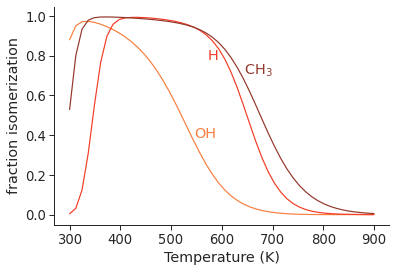

In [33]:
if not multi_panel:
    f, ax = plt.subplots()
else:
    ax = axes[0][1]
vlocation = ['bottom', 'top', 'bottom']
hlocation = ['left', 'right', 'left']
for index, (name, branching_data) in enumerate(plot_data_all.items()):
    try:
        branching_data['isomerization'].plot(ax=ax, color=colors[index])
        y_cross = branching_data.loc[temperatures[20+4*index],'isomerization']
    except KeyError:
        branching_data['isomerization + HO2 production'].plot(ax=ax, color=colors[index])
        y_cross = branching_data.loc[temperatures[20+4*index],'isomerization + HO2 production']
    ax.annotate(name,(temperatures[20+4*index],y_cross), color=colors[index], verticalalignment=vlocation[index],horizontalalignment=hlocation[index])
ax.set_ylabel('fraction isomerization')
ax.set_xlabel('Temperature (K)')
sns.despine()

In [34]:
if not multi_panel:
    f.savefig(os.path.join(image_path,'isomerization_with_temp_and_structure.svg'),bbox_inches='tight')

# get combustion OH production

In [35]:
radical_production_series = radical_production_table['OH_split']

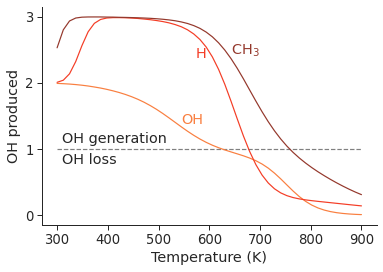

In [36]:
if not multi_panel:
    f, ax = plt.subplots()
else:
    ax = axes[1][1]
ax.plot([300, 900], [1,1], linestyle='--', color=[.5,.5,.5], )
ax.annotate('OH generation', (310,1.05), va='bottom')
ax.annotate('OH loss', (310,1-.05), va='top')
vlocation = ['bottom', 'top', 'bottom']
hlocation = ['left', 'right', 'left']
for index, (name, data) in enumerate(plot_data_all.items()):
    radical_production = (radical_production_series * data).sum(1)
    radical_production.plot(ax=ax, color=colors[index])
    y_cross = radical_production[temperatures[20+4*index]]
    ax.annotate(name,(temperatures[20+4*index],y_cross), color=colors[index], verticalalignment=vlocation[index],horizontalalignment=hlocation[index])
ax.set_ylabel('OH produced')
ax.set_xlabel('Temperature (K)')
ax.set_yticks([0,1,2,3])

sns.despine()

In [37]:
if not multi_panel:
    f.savefig(os.path.join(image_path,'OH_with_temp_and_structure.svg'),bbox_inches='tight')